<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint12_conv2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimpleConv2d

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## [Problem 3] Output size after 2-dimensional convolution

In [65]:
def output_shape(in_h, in_w, filter_h, filter_w, padding_h=0, padding_w=0, stride_h=1, stride_w=1):
    out_h = (in_h + 2*padding_h - filter_h) / stride_h + 1
    out_w = (in_w + 2*padding_w - filter_w) / stride_w + 1
    return int(out_h), int(out_w)

## [Problem 1] Creating a 2-D convolutional layer

In [66]:
# Forward
def forward(X, W, B, padding_size=(0, 0), stride_size=(1, 1)):
    N, CHANNEL_SIZE, HEIGHT, WIDTH = X.shape
    FILTER_SIZE, CHANNEL_SIZE, FILTER_HEIGHT, FILTER_WIDTH = W.shape
    X_pad = np.pad(X, ((0, 0), (0, 0), padding_size, padding_size))

    out_h, out_w = output_shape(HEIGHT, WIDTH, FILTER_HEIGHT, FILTER_WIDTH, *padding_size, *stride_size)
    A = np.zeros((N, FILTER_SIZE, out_h, out_w))

    for n in range(N):
        for out_chn in range(FILTER_SIZE):
            for row in range(0, HEIGHT - FILTER_HEIGHT + 1, stride_size[0]):
                for col in range(0, WIDTH - FILTER_WIDTH + 1, stride_size[1]):
                    A[n, out_chn, row, col] = np.sum(X_pad[n, :, row:row + FILTER_HEIGHT, col:col + FILTER_WIDTH] * W[out_chn,:,:,:]) + B[out_chn]

    return A

def backward(X, W, B, dA, padding_size=(0, 0), stride_size=(1, 1)):
    N, CHANNEL_SIZE, HEIGHT, WIDTH = X.shape
    FILTER_SIZE, CHANNEL_SIZE, FILTER_HEIGHT, FILTER_WIDTH = W.shape
    N, FILTER_SIZE, OUT_H, OUT_W = dA.shape
    X_pad = np.pad(X, ((0, 0), (0, 0), padding_size, padding_size))

    dW = np.zeros(W.shape)
    dB = np.zeros(B.shape)
    dZ = np.zeros(X_pad.shape)

    # dB
    for out_chn in range(FILTER_SIZE):
        dB[out_chn] = np.sum(dA[:, out_chn, :, :])

    # dZ & dW
    for i in range(N):
        for out_chn in range(FILTER_SIZE):
            for row in range(OUT_H):
                for col in range(OUT_W):
                    s_row, s_col = row * stride_size[0], col * stride_size[1]
                    dW[out_chn,:,:,:] += dA[i, out_chn, row, col] * X_pad[i, :, s_row:s_row+FILTER_HEIGHT, s_col:s_col+FILTER_WIDTH]
                    dZ[i, :, s_row:s_row+FILTER_HEIGHT, s_col:s_col+FILTER_WIDTH] += dA[i, out_chn, row, col] * W[out_chn,:,:,:]
    
    delete_rows = range(padding_size[0]), range(HEIGHT + padding_size[0], HEIGHT + 2*padding_size[0], 1)
    delete_cols = range(padding_size[1]), range(WIDTH + padding_size[1], WIDTH + 2*padding_size[1], 1)
    dZ = np.delete(dZ, delete_rows, axis=2)
    dZ = np.delete(dZ, delete_cols, axis=3)
    
    return dZ, dW, dB

## [Problem 2] Experiments with 2D convolutional layers on small arrays

In [67]:
# (1,1,4,4): 1 sample, 1 channel, 4 x 4
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,1,3,3): 2 filter size, 1 channel, 3 x 3
w = np.array([[[[ 0.,  0.,  0.],
                [ 0.,  1.,  0.],
                [ 0., -1.,  0.]]],
              [[[ 0.,  0.,  0.],
                [ 0., -1.,  1.],
                [ 0.,  0.,  0.]]]])
b = np.zeros(2)

In [68]:
forward(x, w, b)

array([[[[-4., -4.],
         [-4., -4.]],

        [[ 1.,  1.],
         [ 1.,  1.]]]])

In [69]:
delta = np.array([[[[ -4,  -4],
                    [ 10,  11]],
                   [[  1,  -7],
                    [  1, -11]]]])
dZ, dW, dB = backward(x, w, b, delta)

In [70]:
print(dZ)
print(dW)
print(dB)

[[[[  0.   0.   0.   0.]
   [  0.  -5.   4.  -7.]
   [  0.  13.  27. -11.]
   [  0. -10. -11.   0.]]]]
[[[[ 104.  117.  130.]
   [ 156.  169.  182.]
   [ 208.  221.  234.]]]


 [[[ -74.  -90. -106.]
   [-138. -154. -170.]
   [-202. -218. -234.]]]]
[ 13. -16.]


## [Problem 4] Creation of maximum pooling layer

In [71]:
class MaxPool2D:
    def __init__(self, pool_size=(2, 2)):
        self.PH, self.PW = pool_size
    
    def forward(self, X):
        self.N, self.C, self.IN_H, self.IN_W = X.shape
        self.OUT_H, self.OUT_W = int(self.IN_H / self.PH), int(self.IN_W / self.PW)

        # Pooling filter
        self.A = np.zeros((self.N, self.C, self.OUT_H, self.OUT_W))
        self.index = np.zeros((self.N, self.C, self.OUT_H, self.OUT_W))

        for i in range(self.N):
            for chn in range(self.C):
                for row in range(self.OUT_H):
                    for col in range(self.OUT_W):
                        self.A[i, chn, row, col] = np.max(X[i, chn, row*self.PH:(row+1)*self.PH, col*self.PW:(col+1)*self.PW])
                        self.index[i, chn, row, col] = np.argmax(X[i, chn, row*self.PH:(row+1)*self.PH, col*self.PW:(col+1)*self.PW])

        return self.A

    def backward(self, d):
        dZ = np.zeros((self.N, self.C, self.IN_H, self.IN_W))

        for i in range(self.N):
            for chn in range(self.C):
                for row in range(self.OUT_H):
                    for col in range(self.OUT_W):
                        idx = self.index[i, chn, row, col]
                        tmp = np.array([d[i, chn, row, col] if j == idx else 0 for j in range(self.PH * self.PW)])
                        dZ[i, chn, row*self.PH:(row+1)*self.PH, col*self.PW:(col+1)*self.PW] = tmp.reshape(self.PH, self.PW)
        return dZ

In [72]:
X = np.random.randint(0, 9, 36).reshape(1, 1, 6, 6)
X

array([[[[8, 4, 3, 5, 7, 1],
         [5, 4, 3, 5, 4, 5],
         [7, 5, 6, 8, 4, 3],
         [0, 8, 5, 4, 1, 2],
         [4, 6, 4, 3, 4, 4],
         [8, 4, 6, 3, 7, 3]]]])

In [73]:
max_pool = MaxPool2D((2, 2))
A = max_pool.forward(X)
print(A)
print(max_pool.index)

[[[[8. 5. 7.]
   [8. 8. 4.]
   [8. 6. 7.]]]]
[[[[0. 1. 0.]
   [3. 1. 0.]
   [2. 2. 2.]]]]


In [74]:
dA = np.array([[[[0, 1, 2],
                 [1, 1, -1],
                 [0, -2, 1]]]])
max_pool.backward(dA)

array([[[[ 0.,  0.,  0.,  1.,  2.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0., -2.,  0.,  1.,  0.]]]])

## [Problem 5] (Advance task) Creating average pooling

In [75]:
class AveragePool2D:
    def __init__(self, pool_size=(2, 2)):
        self.PH, self.PW = pool_size
    
    def forward(self, X):
        self.N, self.C, self.IN_H, self.IN_W = X.shape
        self.OUT_H, self.OUT_W = int(self.IN_H / self.PH), int(self.IN_W / self.PW)

        # Pooling filter
        self.A = np.zeros((self.N, self.C, self.OUT_H, self.OUT_W))
        self.index = np.zeros((self.N, self.C, self.OUT_H, self.OUT_W))

        for i in range(self.N):
            for chn in range(self.C):
                for row in range(self.OUT_H):
                    for col in range(self.OUT_W):
                        self.A[i, chn, row, col] = np.mean(X[i, chn, row*self.PH:(row+1)*self.PH, col*self.PW:(col+1)*self.PW])

        return self.A

    def backward(self, d):
        dZ = np.zeros((self.N, self.C, self.IN_H, self.IN_W))

        for i in range(self.N):
            for chn in range(self.C):
                for row in range(self.OUT_H):
                    for col in range(self.OUT_W):
                        tmp = np.array([d[i, chn, row, col] / (self.PH * self.PW) for j in range(self.PH * self.PW)])
                        dZ[i, chn, row*self.PH:(row+1)*self.PH, col*self.PW:(col+1)*self.PW] = tmp.reshape(self.PH, self.PW)       
        return dZ

In [76]:
X = np.random.randint(0, 9, 36).reshape(1, 1, 6, 6)
X

array([[[[2, 5, 8, 0, 4, 4],
         [0, 3, 1, 6, 8, 4],
         [1, 4, 2, 8, 2, 1],
         [6, 7, 5, 0, 6, 8],
         [2, 2, 1, 4, 1, 8],
         [0, 4, 5, 5, 3, 4]]]])

In [77]:
avg_pool = AveragePool2D((2, 2))
A = avg_pool.forward(X)
print(A)

[[[[2.5  3.75 5.  ]
   [4.5  3.75 4.25]
   [2.   3.75 4.  ]]]]


In [78]:
dA = np.array([[[[0, 1, 2],
                 [1, 1, -1],
                 [0, -2, 1]]]])
avg_pool.backward(dA)

array([[[[ 0.  ,  0.  ,  0.25,  0.25,  0.5 ,  0.5 ],
         [ 0.  ,  0.  ,  0.25,  0.25,  0.5 ,  0.5 ],
         [ 0.25,  0.25,  0.25,  0.25, -0.25, -0.25],
         [ 0.25,  0.25,  0.25,  0.25, -0.25, -0.25],
         [ 0.  ,  0.  , -0.5 , -0.5 ,  0.25,  0.25],
         [ 0.  ,  0.  , -0.5 , -0.5 ,  0.25,  0.25]]]])

## [Problem 6] Smoothing

In [79]:
class Flatten:
    def __init__(self):
        self.name = "Flatten"
    
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(len(X), -1)
    
    def backward(self, X):
        return X.reshape(self.shape)

In [80]:
X = np.zeros((20, 2, 5, 5))
flatten = Flatten()
X_flat = flatten.forward(X)
print("Forward:", X_flat.shape)
print("Backward:", flatten.backward(X_flat).shape)

Forward: (20, 50)
Backward: (20, 2, 5, 5)


## SimpleConv2d class

In [81]:
class SimpleInitializerConv2d:
    def __init__(self, sigma=0.02, seed=None):
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)

    def init(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W

In [82]:
class SimpleConv2d:
    def __init__(self, out_channel, in_channel, filter_size,
                 padding_size=(0, 0), stride_size=(1, 1),
                 initializer=None, optimizer=None, activation=None):
        self.OUT_CHN = out_channel
        self.IN_CHN = in_channel
        self.FH, self.FW = filter_size
        self.PH, self.PW = padding_size
        self.SH, self.SW = stride_size

        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        self.W = self.initializer.init(self.OUT_CHN, self.IN_CHN, self.FH, self.FW)
        self.B = self.initializer.init(self.OUT_CHN)
    
    def output_shape(self, IN_H, IN_W):
        out_h = (IN_H + 2 * self.PH - self.FH) / self.SH + 1
        out_w = (IN_W + 2 * self.PW - self.FW) / self.SW + 1
        return int(out_h), int(out_w)
    
    def forward(self, X):
        self.input = X
        self.N, self.IN_CHN, self.IN_H, self.IN_W = X.shape
        self.OUT_H, self.OUT_W = self.output_shape(self.IN_H, self.IN_W)

        self.A = np.zeros((self.N, self.OUT_CHN, self.OUT_H, self.OUT_W))
        self.X_pad = np.pad(self.input, ((0, 0), (0, 0), (self.PH, self.PW), (self.PH, self.PW)))

        for i in range(self.N):
            for out_chn in range(self.OUT_CHN):
                for row in range(0, self.IN_H - self.FH + 1, self.SH):
                    for col in range(0, self.IN_W - self.FW + 1, self.SW):
                        self.A[i, out_chn, row, col] = \
                            np.sum(self.X_pad[i, :, row:row+self.FH, col:col+self.FW] * self.W[out_chn,:,:,:]) + self.B[out_chn]

        self.output = self.activation.forward(self.A)
        return self.output
    
    def backward(self, d):
        dA = self.activation.backward(d)
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        dZ = np.zeros(self.X_pad.shape)

        # dB
        for out_chn in range(self.OUT_CHN):
            self.dB[out_chn] = np.sum(dA[:, out_chn, :, :])

        # dZ & dW
        for i in range(self.N):
            for out_chn in range(self.OUT_CHN):
                for row in range(0, self.OUT_H):
                    for col in range(0, self.OUT_W):
                        s_row, s_col = row * self.SH, col * self.SW
                        self.dW[out_chn,:,:,:] += dA[i, out_chn, row, col] * self.X_pad[i, :, s_row:s_row + self.FH, s_col:s_col + self.FW]
                        dZ[i, :, s_row:s_row + self.FH, s_col:s_col + self.FW] += dA[i, out_chn, row, col] * self.W[out_chn,:,:,:]
        
        delete_rows = range(self.PH), range(self.IN_H + self.PH, self.IN_H + 2 * self.PH, 1)
        delete_cols = range(self.PW), range(self.IN_W + self.PW, self.IN_W + 2 * self.PW, 1)
        dZ = np.delete(dZ, delete_rows, axis=2)
        dZ = np.delete(dZ, delete_cols, axis=3)

        self.optimizer.update(self)
        return dZ

## [Problem 7] Learning and estimation

### Helper functions

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

def evaluate(X, y, y_one_hot, model):
    y_proba = model.predict_proba(X)
    y_pred = np.argmax(y_proba, axis=1)
    print("ROC AUC:", roc_auc_score(y_one_hot, y_proba))
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), cmap=plt.cm.Blues, annot=True)
    plt.show()
    
def plot_learning_curve(train_loss, val_loss=None):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, 'bo--', label="train_loss", linewidth=5)
    if val_loss is not None or len(val_loss) > 0:
        plt.plot(val_loss, 'rs--', label="val_loss", linewidth=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

In [84]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [85]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.name = "SGD"
        
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.name = "AdaGrad"
        self.hW = 0
        self.hB = 0

    def update(self, layer):
        self.hW += layer.dW ** 2
        self.hB = layer.dB ** 2

        layer.W -= self.lr * layer.dW / (np.sqrt(self.hW) + 1e-7)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.hB) + 1e-7)

        return layer

In [86]:
class Softmax:
    def __init__(self):
        self.name = "softmax"
    def forward(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
    def backward(self, dZ):
        return dZ
        
class ReLU:
    def __init__(self):
        self.name = "ReLU"
    def forward(self, X):
        self.X = X
        return np.maximum(self.X, 0)
    def backward(self, dZ):
        return np.where(self.X > 0, dZ, 0)

In [87]:
class SimpleInitializer:
    def __init__(self, sigma=0.02, seed=None):
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
        
class XavierInitializer:
    def __init__(self, seed=None):
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class HeInitializer:
    def __init__(self, seed=None):
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [88]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer,
                 activation, optimizer, bias=True):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.activation = activation
        self.optimizer = optimizer
        self.bias = bias
        self._init_weights()
    
    def _init_weights(self):
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        self.input = X
        self.A = self.input @ self.W + self.B if self.bias else self.input @ self.W
        return self.activation.forward(self.A)

    def backward(self, d):
        dA = self.activation.backward(d)

        self.dW = self.input.T @ dA / len(self.input)
        self.dB = np.mean(dA, axis=0)
        dZ = dA @ self.W.T
        
        self.optimizer.update(self)
        return dZ

In [89]:
class ScratchCNNClassifier:
    def __init__(self, batch_size=1, epochs=10, layers=[],
                 random_state=None, verbose=False):
        self.batch_size = batch_size
        self.epochs = epochs
        self.layers = layers.copy()
        self.random_state = random_state
        self.verbose = verbose

    def add_layer(self, layer):
        self.layers.append(layer)

    def loss_function(self, y_true, y_proba, tol=1e-7):
        L = -np.mean(y_true * np.log(y_proba + tol))
        return L
    
    def _feedforward(self, X):
        Z = X.copy()
        for layer in self.layers:
            Z = layer.forward(Z)
        return Z
    
    def _backpropagation(self, d):
        dZ = d
        for layer in self.layers[::-1]:
            dZ = layer.backward(dZ)
        
    def fit(self, X, y, X_val=None, y_val=None):
        self.train_loss = []
        self.val_loss = []
        for i in range(self.epochs):
            mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=self.random_state)
            loss = 0
            for mini_X, mini_y in mini_batch:

                # Forward
                Z = self._feedforward(mini_X[:, np.newaxis, :, :])

                # Backward
                dZ = (Z - mini_y) / self.batch_size
                self._backpropagation(dZ)
                
                # Accumulate loss
                loss += self.loss_function(mini_y, Z)

            self.train_loss.append(loss / len(mini_batch))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self.loss_function(y_val, self.predict_proba(X_val)))

            if self.verbose:
                print("Epoch", i, "Loss:", self.train_loss[-1])

        return self
    
    def predict_proba(self, X):
        return self._feedforward(X[:, np.newaxis, :, :])

    def predict(self, X):
        y_proba = self.predict_proba(X)
        return np.argmax(y_proba, axis=1)

### Prepare data

In [90]:
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()
X = X.astype(np.float)
X_test = X_test.astype(np.float)
X /= 255
X_test /= 255

In [91]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y.reshape(-1, 1))
y_test_one_hot = enc.transform(y_test.reshape(-1, 1))

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val, y_train_one_hot, y_val_one_hot = train_test_split(X, y, y_one_hot, test_size=0.2, random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape, y_train_one_hot.shape, y_val_one_hot.shape

((48000, 28, 28),
 (12000, 28, 28),
 (48000,),
 (12000,),
 (48000, 10),
 (12000, 10))

### Train

In [93]:
FC1 = FC(7840, 400, initializer=HeInitializer(), activation=ReLU(), optimizer=AdaGrad(0.01))
FC2 = FC(400, 200, initializer=HeInitializer(), activation=ReLU(), optimizer=AdaGrad(0.01))
FC3 = FC(200, 10, initializer=SimpleInitializer(0.01), activation=Softmax(), optimizer=AdaGrad(0.01))
conv2d = SimpleConv2d(out_channel=10, in_channel=1, filter_size=(3, 3), padding_size=(1, 1), stride_size=(1, 1),
                      initializer=SimpleInitializerConv2d(), optimizer=SGD(), activation=ReLU())

cnn = ScratchCNNClassifier(batch_size=200, epochs=10, verbose=True)
cnn.add_layer(conv2d)
cnn.add_layer(Flatten())
cnn.add_layer(FC1)
cnn.add_layer(FC2)
cnn.add_layer(FC3)

In [94]:
cnn.fit(X_train[:1000], y_train_one_hot[:1000])

Epoch 0 Loss: 0.22619883214679418
Epoch 1 Loss: 0.22573381427106032
Epoch 2 Loss: 0.18690469468081913
Epoch 3 Loss: 0.12168566792666433
Epoch 4 Loss: 0.08733665176036635
Epoch 5 Loss: 0.06514720554496449
Epoch 6 Loss: 0.05187248682350848
Epoch 7 Loss: 0.04942063352655427
Epoch 8 Loss: 0.038258093775095314
Epoch 9 Loss: 0.03328667729296013


ROC AUC: 0.9895606642819939
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1205
           1       0.94      0.96      0.95      1379
           2       0.89      0.87      0.88      1166
           3       0.93      0.84      0.88      1208
           4       0.72      0.92      0.81      1153
           5       0.87      0.69      0.77      1075
           6       0.92      0.94      0.93      1190
           7       0.94      0.89      0.91      1228
           8       0.70      0.93      0.80      1191
           9       0.84      0.63      0.72      1205

    accuracy                           0.86     12000
   macro avg       0.87      0.86      0.86     12000
weighted avg       0.87      0.86      0.86     12000



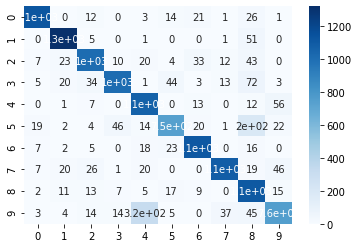

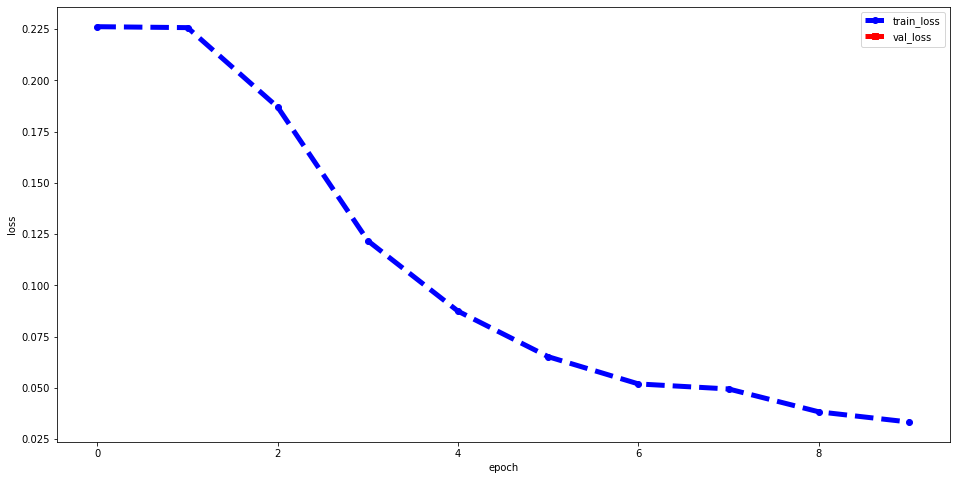

In [95]:
evaluate(X_val, y_val, y_val_one_hot, cnn)
plot_learning_curve(cnn.train_loss, cnn.val_loss)

## [Problem 8] (Advance assignment) LeNet

In [96]:
conv2d_1 = SimpleConv2d(out_channel=6, in_channel=1, filter_size=(5, 5), padding_size=(2, 2), stride_size=(1, 1),
                      initializer=SimpleInitializerConv2d(), optimizer=SGD(), activation=ReLU())
max_pool_1 = MaxPool2D(pool_size=(2, 2))
conv2d_2 = SimpleConv2d(out_channel=16, in_channel=6, filter_size=(5, 5), padding_size=(2, 2), stride_size=(1, 1),
                        initializer=SimpleInitializerConv2d(), optimizer=SGD(), activation=ReLU())
max_pool_2 = MaxPool2D(pool_size=(2, 2))
flatten = Flatten()
FC1 = FC(784, 120, initializer=HeInitializer(), activation=ReLU(), optimizer=AdaGrad(0.01))
FC2 = FC(120, 84, initializer=HeInitializer(), activation=ReLU(), optimizer=AdaGrad(0.01))
FC3 = FC(84, 10, initializer=SimpleInitializer(0.01), activation=Softmax(), optimizer=AdaGrad(0.01))

In [97]:
LeNet = ScratchCNNClassifier(batch_size=20, epochs=30, verbose=True)
LeNet.add_layer(conv2d_1)
LeNet.add_layer(max_pool_1)
LeNet.add_layer(conv2d_2)
LeNet.add_layer(max_pool_2)
LeNet.add_layer(flatten)
LeNet.add_layer(FC1)
LeNet.add_layer(FC2)
LeNet.add_layer(FC3)

In [98]:
LeNet.fit(X_train[:1000], y_train_one_hot[:1000])

Epoch 0 Loss: 0.2292090381285413
Epoch 1 Loss: 0.1847563054002919
Epoch 2 Loss: 0.11810638536960326
Epoch 3 Loss: 0.09192137662125538
Epoch 4 Loss: 0.07831324307216189
Epoch 5 Loss: 0.06720373560271825
Epoch 6 Loss: 0.06020304636096808
Epoch 7 Loss: 0.05267893832132297
Epoch 8 Loss: 0.047557111094987586
Epoch 9 Loss: 0.043017705907549095
Epoch 10 Loss: 0.039288207117629065
Epoch 11 Loss: 0.03685135170049707
Epoch 12 Loss: 0.03271650735486981
Epoch 13 Loss: 0.03094006372146652
Epoch 14 Loss: 0.028468327560905626
Epoch 15 Loss: 0.025143179914210292
Epoch 16 Loss: 0.02447238432485939
Epoch 17 Loss: 0.02276939922785734
Epoch 18 Loss: 0.02107013732457446
Epoch 19 Loss: 0.01955946969325007
Epoch 20 Loss: 0.01770053650508162
Epoch 21 Loss: 0.017099183001621263
Epoch 22 Loss: 0.015184432113735893
Epoch 23 Loss: 0.013267790651355851
Epoch 24 Loss: 0.013285574807050142
Epoch 25 Loss: 0.011668471159832558
Epoch 26 Loss: 0.011362351305914637
Epoch 27 Loss: 0.010572919231199336
Epoch 28 Loss: 0.009

ROC AUC: 0.9951993647166013
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1205
           1       0.97      0.95      0.96      1379
           2       0.92      0.91      0.91      1166
           3       0.91      0.91      0.91      1208
           4       0.95      0.87      0.91      1153
           5       0.89      0.87      0.88      1075
           6       0.96      0.95      0.95      1190
           7       0.96      0.90      0.93      1228
           8       0.84      0.92      0.88      1191
           9       0.81      0.93      0.87      1205

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



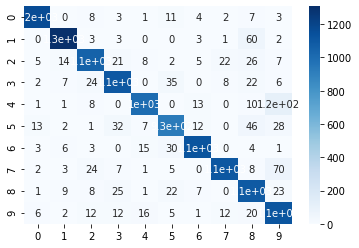

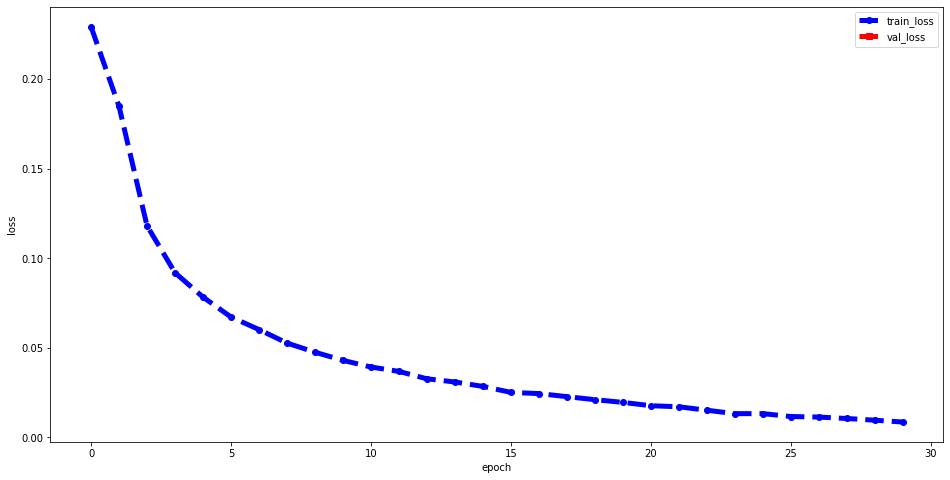

In [99]:
evaluate(X_val, y_val, y_val_one_hot, LeNet)
plot_learning_curve(LeNet.train_loss, LeNet.val_loss)

## [Problem 9] (Advance assignment) Survey of famous image recognition models

### AlexNet

Proposed by Alex Krizhev and his colleagues. Consist of 5 convolutional layers and 3 fully connected layers

0.   Input: 227 x 227 x 3
1.   Convolution 1: 96 output channels, filter size 11 x 11, stride 4, ReLU activation
2.   Max Pooling: 3 x 3, stride 2
3.   Convolution 2: 256 output channels, filter size 5 x 5, stride 1, padding 2, ReLU activaion
4.   Max Pooling: 3 x 3, stride 2
5.   Convolution 3: 384 output channels, filter size 3 x 3, stride 1, padding 1, ReLU activation
6.   Convolution 4: 384 output channels, filter size 3 x 3, stride 1, padding 1, ReLU activation
7.   Convolution 5: 256 output channels, filter size 3 x 3, stride 1, padding 1, ReLU activation
8.   Max Pooling: 3 x 3, stride 2
9.   Smoothing
10.  Fully connected layer: 4096 output nodes, dropout 0.5, ReLU activation
11.  Fully connected layer: 4096 output nodes, dropout 0.5, ReLU activation
12.  Fully connected layer: 1000 output nodes, Softmax activation
**-> AlexNet has a total of 62.3 million learnable parameters.**

### VGG16

Proposed by K. Simonyan and A. Zisserman. Consist of 13 convolutional layers and 3 fully connected layers.

0.   Input: 224, 224, 3
1.   Convolution 1: 64 output channels, filter size 3 x 3, ReLU activation
2.   Convolution 2: 64 output channels, filter size 3 x 3, ReLU activation
3.   Max pooling: 2 x 2
4.   Convolution 3: 128 output channels, filter size 3 x 3, ReLU activation
5.   Convolution 4: 128 output channels, filter size 3 x 3, ReLU activation
6.   Max pooling: 2 x 2
7.   Convolution 5: 256 output channels, filter size 3 x 3, ReLU activation
8.   Convolution 6: 256 output channels, filter size 3 x 3, ReLU activation
9.   Convolution 7: 256 output channels, filter size 3 x 3, ReLU activation
10.  Max pooling: 2 x 2
11.   Convolution 8: 512 output channels, filter size 3 x 3, ReLU activation
12.   Convolution 9: 512 output channels, filter size 3 x 3, ReLU activation
13.   Convolution 10: 512 output channels, filter size 3 x 3, ReLU activation
14.  Max pooling: 2 x 2
15.   Convolution 11: 512 output channels, filter size 3 x 3, ReLU activation
16.   Convolution 12: 512 output channels, filter size 3 x 3, ReLU activation
17.   Convolution 13: 512 output channels, filter size 3 x 3, ReLU activation
18.  Max pooling: 2 x 2
19.  Smoothing
20.  Fully connected layer: 4096 output nodes, dropout 0.5, ReLU activation
21.  Fully connected layer: 4096 output nodes, dropout 0.5, ReLU activation
22.  Fully connected layer: 1000 output nodes, dropout 0.5, Softmax activation

**-> VGG16 has a total of 138 million learnable parameters.**